In [240]:
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from itertools import combinations
from scipy.stats import wilcoxon, ttest_rel
from scipy import stats
from matplotlib.lines import Line2D

In [290]:
def plot_by_block_grouped_by_patient(
    df,
    marker_col="B7-H3",
    patient_col="Patient ID",
    block_col="BlockID",
    tissue_col="Tissue",
    primary_col = "Tissue",
    ddof=1,
    ax=None,
    palette: dict | None = None,

    # presentation
    vline_color="lightgray",
    vline_alpha=1.0,
    title: str | None = None,
    label_fontsize=12,
    tick_fontsize=10,
    legend_point_size=8,
    xlabel_pad: float = 10,
    xtick_pad: float = 2, 
    xlabel_angle: float = 0, 
    x_label: str = "Patient",

    # arrows for Primary
    primary_label: str = "Primary", 
    arrow_color: str = "black",
    arrow_linewidth: float = 1.6,    # shaft thickness
    arrow_head_size: float = 9.0,    # head size
    arrow_pad: float = 8.0,          # gap above top of error bar (data units)
    arrow_len: float = 28.0,          # arrow length (data units)

    # y-axis floor
    ymin_floor: float = 0.0
):
    d = df.copy()
    d[marker_col] = pd.to_numeric(d[marker_col], errors="coerce")
    d = d.dropna(subset=[marker_col])

    # --- NEW: remember the desired tissue category order (if provided on df) ---
    tissue_cats = None
    if pd.api.types.is_categorical_dtype(df[tissue_col]):
        tissue_cats = list(df[tissue_col].cat.categories)
        tissue_cats_str = [str(c) for c in tissue_cats]
        tissue_ordered = df[tissue_col].cat.ordered
    else:
        tissue_ordered = False

    # aggregate within (Patient, Block)
    agg = (
        d.groupby([patient_col, block_col], dropna=False, observed=True)
         .apply(lambda g: pd.Series({
             "mean": g[marker_col].mean(),
             "sd":   g[marker_col].std(ddof=ddof),
             "n":    len(g),
             tissue_col: g[tissue_col].mode(dropna=False).iat[0]
                         if not g[tissue_col].mode(dropna=False).empty else np.nan, 
             primary_col: g[primary_col].mode(dropna=False).iat[0]
                         if not g[primary_col].mode(dropna=False).empty else np.nan
         }))
         .reset_index()
         .sort_values([patient_col, block_col], kind="stable")
         .reset_index(drop=True)
    )

    if tissue_cats is not None:
        agg[tissue_col] = pd.Categorical(agg[tissue_col], categories=tissue_cats, ordered=tissue_ordered)

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 5))
    else:
        fig = ax.figure

    # positions & arrays
    x = np.arange(len(agg))
    y = agg["mean"].to_numpy()
    # yerr: NaN if n<2 so no bar; we’ll handle that
    yerr = np.where(agg["n"].to_numpy() >= 2, agg["sd"].to_numpy(), np.nan)

    # patient boundaries + centers
    boundaries, centers, labels = [], [], []
    start = 0
    for pid, sub in agg.groupby(patient_col, sort=False):
        n = len(sub)
        if start > 0:
            boundaries.append(start - 0.5)
        centers.append(start + (n - 1) / 2.0)
        labels.append(str(pid))
        start += n

    if pd.api.types.is_categorical_dtype(agg[tissue_col]):
        present_str = agg[tissue_col].dropna().astype(str).unique().tolist()
        present_set = set(present_str)
        uniq_tissues = [s for s in tissue_cats_str if s in present_set]
    else:
        uniq_tissues = list(dict.fromkeys(agg[tissue_col].astype(str).tolist()))

    # strings for comparisons/legend labels
    tseries = agg[tissue_col].astype(object)
    tseries_str = agg[tissue_col].astype(str)
    uniq_tissues = [str(t) for t in tissue_cats]  # legend/order

    # palette
    if palette is None:
        base = TABLEAU10 if len(uniq_tissues) <= 10 else (TABLEAU10 + SET2)
        palette = {t: base[i % len(base)] for i, t in enumerate(uniq_tissues)}
    else:
        base = TABLEAU10 + SET2
        palette = palette.copy()
        fill_i = 0
        for t in uniq_tissues:
            if t not in palette:
                palette[t] = base[fill_i % len(base)]
                fill_i += 1

    # draw per tissue
    print(uniq_tissues)
    for t in uniq_tissues:
        m = (tseries_str == t) 
        if not np.any(m): 
            continue
        ax.errorbar(
            x[m], y[m], yerr=yerr[m],
            fmt='o', linestyle='none', capsize=3, markeredgewidth=0.8,
            mfc=palette[t], mec=palette[t], ecolor=palette[t]
        )

    # --- arrows above the TOP of error bar (or point if no error bar) ---
    if primary_label is not None:
        tseries_pc = agg[primary_col].astype(str)
        pmask = (tseries_pc == str(primary_label))
        if np.any(pmask):
            # top of bar: mean + yerr (0 if NaN)
            yerr_safe = np.nan_to_num(yerr, nan=0.0)
            tops = y[pmask] + yerr_safe[pmask]
            xs = x[pmask]
            # tip just above the top; tail higher so arrow faces downward
            for xi, ytop in zip(xs, tops):
                tip   = ytop + arrow_pad
                tail  = tip  + arrow_len
                ax.annotate(
                    "", xy=(xi, tip), xytext=(xi, tail),
                    arrowprops=dict(
                        arrowstyle='-|>',
                        color=arrow_color,
                        lw=arrow_linewidth,
                        mutation_scale=arrow_head_size,
                        shrinkA=0, shrinkB=0,
                        capstyle='butt'
                    ),
                    annotation_clip=False
                )

    # separators
    cur_ymin, cur_ymax = ax.get_ylim()
    for b in boundaries:
        ax.vlines(b, 0, 350, linestyles='dashed', linewidth=1,
                  color=vline_color, alpha=vline_alpha)

    # ensure y starts at 0 and accommodates arrows if needed
    # recompute max considering potential arrows extending above current ymax
    if primary_label is not None and np.any(pmask):
        max_arrow_top = np.max(tops + arrow_pad + arrow_len)
        cur_ymax = max(cur_ymax, max_arrow_top * 1.02)
    ax.set_ylim(bottom=ymin_floor, top=cur_ymax)
    ax.set_ylim(0,300)

    # axes
    ax.set_xticks(centers)
    ax.set_xticklabels(labels, fontsize=tick_fontsize, rotation=xlabel_angle, ha='right')
    ax.tick_params(axis='x', pad=xtick_pad)
    ax.set_xlabel(x_label, fontsize=label_fontsize, labelpad=xlabel_pad)
    ax.set_ylabel(marker_col + " (H-Score)", fontsize=label_fontsize)
    
    if title is not None:
        ax.set_title(title, fontsize=label_fontsize)
    ax.tick_params(axis='y', labelsize=tick_fontsize)

    # legend handles
    handles = [Line2D([0],[0], marker='o', linestyle='none',
                      color=palette[t], label=t, markersize=legend_point_size)
               for t in uniq_tissues]
    return fig, ax, handles, uniq_tissues


In [291]:
def boxplot_hscore_by_patient(
    df: pd.DataFrame,
    marker_col: str = "B7-H3",
    patient_col: str = "Patient ID",
    sort_by: str = "patient",       # "patient" | "median" | "count"
    ax=None,
    # presentation options
    title: str | None = None,       # None => no title
    point_color: str = "#6E6E6E",   # pleasant gray
    point_alpha: float = 0.6,
    point_size: float = 18,         # markersize in points^2 (see below)
    rotate_xticks: int = 45,
    label_fontsize: int = 14,       # axis titles
    tick_fontsize: int = 12,        # tick labels
    median_color: str = "#E15759",
    xlabel_pad: float = 10,         # space between x-axis label and ticks
    x_label: str = "Patient",
    ylabel_pad: float = 6           # space between y-axis label and ticks
):
    d = df.copy()
    d[marker_col] = pd.to_numeric(d[marker_col], errors="coerce")
    d = d.dropna(subset=[marker_col])

    groups = d.groupby(patient_col, dropna=False)[marker_col]
    stats = groups.agg(count="size", median="median").reset_index()
    if sort_by == "median":
        stats = stats.sort_values("median", kind="stable")
    elif sort_by == "count":
        stats = stats.sort_values("count", ascending=False, kind="stable")
    else:
        stats = stats.sort_values(patient_col, kind="stable")

    patient_order = stats[patient_col].tolist()
    labels = [str(p) for p in patient_order]
    data = [groups.get_group(p).values for p in patient_order]

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    else:
        fig = ax.figure

    ax.boxplot(data, labels=labels, showfliers=True, patch_artist=False, medianprops=dict(color=median_color, linewidth=2))

    # uniform-color jittered points
    x = np.arange(1, len(data) + 1)
    for xi, vals in zip(x, data):
        if len(vals) == 0: continue
        jitter = (np.random.rand(len(vals)) - 0.5) * 0.2
        ax.plot(
            np.full_like(vals, xi, dtype=float) + jitter, vals,
            'o', color=point_color, alpha=point_alpha,
            markersize=np.sqrt(point_size)
        )

    # fonts & spacing
    ax.set_xlabel(x_label, fontsize=label_fontsize, labelpad=xlabel_pad)
    ax.set_ylabel(marker_col + " (H-Score)", fontsize=label_fontsize, labelpad=ylabel_pad)
    if title is not None:
        ax.set_title(title, fontsize=label_fontsize)

    ax.set_xticklabels(labels, rotation=rotate_xticks, ha="right", fontsize=tick_fontsize)
    ax.tick_params(axis='y', labelsize=tick_fontsize)
    ax.set_ylim(0,300)

    return fig, ax


In [282]:
def build_panel(
    df,
    palette, 
    patient_col = "Patient ID", 
    tissue_col = "Tissue",
    primary_col = "Tissue",
    legend_row_height=0.42,   # taller legend row to avoid any clash
    hspace=0.45, wspace=0.32,
    label_fontsize=16,        # bigger axis titles everywhere
    tick_fontsize=13,         # bigger tick labels everywhere
    vline_color="#B0B0B0", vline_alpha=0.85,
    legend_bbox_y=0.30,        # vertical placement inside legend row (0=bottom, 1=top)
    legend_point_size=12,
    ncol=8, 
    xlabel_angle = 0, 
    x_label = "Patient"
):
    fig = plt.figure(figsize=(15, 10), constrained_layout=False)
    gs  = fig.add_gridspec(
        nrows=3, ncols=2,
        width_ratios=[3, 1],
        height_ratios=[1, 1, legend_row_height],
        hspace=hspace, wspace=wspace
    )

    ax11 = fig.add_subplot(gs[0, 0])
    ax12 = fig.add_subplot(gs[0, 1])
    ax21 = fig.add_subplot(gs[1, 0])
    ax22 = fig.add_subplot(gs[1, 1])
    axL  = fig.add_subplot(gs[2, :]); axL.axis('off')

    # Wide plots (B7-H3, PSMA). Assumes you already have plot_by_block_grouped_by_patient with font options.
    fig, ax11, handles, labels = plot_by_block_grouped_by_patient(
        df, marker_col="B7-H3",
        patient_col=patient_col, block_col="BlockID", tissue_col=tissue_col,primary_col=primary_col,
        ddof=1, ax=ax11, palette=palette, xlabel_pad=14, xtick_pad=4, xlabel_angle = xlabel_angle, x_label=x_label,
        title=None, label_fontsize=label_fontsize, tick_fontsize=tick_fontsize,
        vline_color=vline_color, vline_alpha=vline_alpha, legend_point_size=legend_point_size
    )
    boxplot_hscore_by_patient(
        df, marker_col="B7-H3", patient_col=patient_col, ax=ax12,
        title=None, point_color="#4B5563", median_color="#EDC948",
        label_fontsize=label_fontsize, tick_fontsize=tick_fontsize,
        xlabel_pad=12, x_label=x_label, ylabel_pad=8
    )

    plot_by_block_grouped_by_patient(
        df, marker_col="PSMA",
        patient_col=patient_col, block_col="BlockID", tissue_col=tissue_col,primary_col=primary_col,
        ddof=1, ax=ax21, palette=palette, xlabel_pad=14, xtick_pad=4, xlabel_angle = xlabel_angle, x_label=x_label,
        title=None, label_fontsize=label_fontsize, tick_fontsize=tick_fontsize,
        vline_color=vline_color, vline_alpha=vline_alpha, legend_point_size=legend_point_size
    )
    boxplot_hscore_by_patient(
        df, marker_col="PSMA", patient_col=patient_col, ax=ax22,
        title=None, point_color="#4B5563", median_color="#EDC948",
        label_fontsize=label_fontsize, tick_fontsize=tick_fontsize,
        xlabel_pad=12, x_label=x_label, ylabel_pad=8
    )

    # LEFT-aligned, horizontal legend in its own ample row
    axL.legend(
        handles, labels,
        loc="center left", bbox_to_anchor=(-0.02, legend_bbox_y),
        ncol=min(ncol, len(labels)), frameon=False, fontsize=legend_point_size,
        handletextpad=0.7, columnspacing=1.3
    )

    return fig


In [244]:
excel_file_path = "/projects/eshenderov-hpc/Shivang/projects/B7-H3 ADC Manuscript/data/Autopsy TMA - Summary Data_.xlsx"
sheet_name = "Per core"

df = pd.read_excel(excel_file_path, sheet_name = sheet_name)

marker_cols = ["B7-H3", "PSMA"]

In [245]:
df.head()

,Patient ID,BlockID,Location,B7-H3,PSMA
0,1924,42751,Left liver,12.546125,24.107143
1,1924,42751,Left liver,38.885201,0.111483
2,1924,42751,Left liver,4.585868,83.465187
3,1924,42762,Hilar LN,100.307312,25.698757
4,1924,42766,Diaphragma,18.85626,25.802752


In [246]:
organ_map = {
    "Left liver": "Liver",
    "Diaphragma": "Muscle",
    "Vertebrae 2": "Bone",
    "Vertebrae 3": "Bone",
    "Vertebrae 1": "Bone",
    "Hilar LN": "Lymph node",
    "LDA": "Primary",
    "Central liver": "Liver",
    "chest wall": "Bone & soft tissue",
    "softtis 5rib": "Bone & soft tissue",
    "chestwall": "Bone & soft tissue",
    "R 3rd rib": "Bone",
    "R 4th rib": "Bone",
    "Periesoph LN": "Lymph node",
    "aortic arch LN": "Lymph node",
    "Invasive RB2": "Primary",
    "IDC RDA": "Primary",
    "Right SV": "Seminal vesicle",
    "Left SV": "Seminal vesicle",
    "Abdominal LN": "Lymph node",
    "Periaort LN": "Lymph node",
    "Post cheswall": "Bone & soft tissue",
    "aortic bif": "Soft tissue",
    "Thoracic ver": "Bone",
    "Lumbar ver": "Bone",
    "Carinal LN": "Lymph node",
    "L 3rd rib": "Bone",
    "LEP": "Primary",
    "Lumbar vert 4": "Bone",
    "Lung L upper": "Lung",
    "lung R lower": "Lung",
    "R Centr Liver": "Liver",
    "R ext Iliac LN": "Lymph node",
    "R Tibia": "Bone",
    "Thoracic 10": "Bone",
    "L adrenal": "Adrenal",
    "paratrach LN": "Lymph node",
    "Cervical 6": "Soft tissue",
    "carinal LN": "Lymph node",
    "Mesenteric LN": "Lymph node",
    "L 10th rib": "Bone",
    "soft tis L rib1": "Bone",
    "R 7th rib": "Bone",
    "paraaortic LN": "Lymph node",
    "Mediastinal LN": "Lymph node",
    "Paraeuso LN": "Lymph node",
    "Right Liver": "Liver",
    "liver philerLN": "Lymph node",
    "LC1": "Primary",
    "Periuret LN": "Lymph node",
    "R lung lower": "Lung",
    "R C iliac LN": "Lymph node",
    "Spleen": "Spleen",
    "L pubis skin": "Skin",
    "R periesop LN": "Lymph node",
    "T11": "Bone",
    "L3": "Bone",
    "L 1st rib": "Bone",
    "L2": "Bone",
    "L medias LN": "Lymph node",
    "T9": "Bone",
    "L1": "Bone",
    "R 1st rib": "Bone",
    "L 3rd Rib": "Bone",
    "T12": "Bone",
    "Left clavicle": "Bone",
    "R 2nd rib": "Bone",
    "R 3rd rib": "Bone",
    "R 5th rib": "Bone",
    "L 5th rib": "Bone",
    "L inguin skin": "Skin",
    "periaort LN": "Lymph node"
}


In [247]:
df["Tissue"] = df["Location"].replace(organ_map)

In [248]:
df.head()

,Patient ID,BlockID,Location,B7-H3,PSMA,Tissue
0,1924,42751,Left liver,12.546125,24.107143,Liver
1,1924,42751,Left liver,38.885201,0.111483,Liver
2,1924,42751,Left liver,4.585868,83.465187,Liver
3,1924,42762,Hilar LN,100.307312,25.698757,Lymph node
4,1924,42766,Diaphragma,18.85626,25.802752,Muscle


In [249]:
pid = df['Patient ID'].unique()
pval = "P" + np.arange(1, len(pid)+1).astype(str)
patient_dict = dict(zip(pid, pval))
df['Patient ID'] = df['Patient ID'].map(patient_dict)

In [250]:
df.head()

,Patient ID,BlockID,Location,B7-H3,PSMA,Tissue
0,P1,42751,Left liver,12.546125,24.107143,Liver
1,P1,42751,Left liver,38.885201,0.111483,Liver
2,P1,42751,Left liver,4.585868,83.465187,Liver
3,P1,42762,Hilar LN,100.307312,25.698757,Lymph node
4,P1,42766,Diaphragma,18.85626,25.802752,Muscle


In [251]:
import pandas as pd

# assuming your DataFrame is named `df`
patient_col = 'Patient ID'
block_col   = 'BlockID'

# Group by both Patient ID and BlockID
summary = (
    df
    .groupby([patient_col, block_col], dropna=False)
    .agg(n = (block_col, 'size'))
    .reset_index()
)

print(summary)
summary['n'].min()

   Patient ID  BlockID  n
0          P1    42751  3
1          P1    42762  1
2          P1    42766  1
3          P1    42770  1
4          P1    42775  3
..        ...      ... ..
62         P6    71397  3
63         P6    71399  3
64         P6    71402  2
65         P6    71406  2
66         P6    71421  3

[67 rows x 3 columns]


np.int64(1)

In [252]:
tissue_dict = {
    "Liver": "Liver", 
    "Lymph node": "Lymph node", 
    "Muscle": "Category 2", 
    "Bone": "Bone", 
    "Primary": "Category 1", 
    "Bone & soft tissue": "Category 2", 
    "Seminal vesicle": "Category 1", 
    "Soft tissue": "Category 2", 
    "Adrenal": "Category 2", 
    "Skin": "Category 2", 
    "Lung": "Lung", 
    "Spleen": "Category 2"
}

df["Tissue_merged"] = df["Tissue"].map(tissue_dict)

In [253]:
patient_col = "Patient ID"
tissue_col = "Tissue_merged"
primary_col = "Tissue"

# Force patient order on the x-axis
patient_order = ["P1","P2","P3","P4","P5","P6"]

# Option A: explicit tissue order
tissue_order = ['Category 1', 'Category 2', 'Liver', 'Bone', 'Lung','Lymph node']

df['Patient ID'] = pd.Categorical(df[patient_col], categories=patient_order, ordered=True)
df['Tissue_merged'] = pd.Categorical(df[tissue_col], categories=tissue_order, ordered=True)

/local/ssharm55/2327612/ipykernel_2052721/41456707.py:41: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[tissue_col]):
/local/ssharm55/2327612/ipykernel_2052721/41456707.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/local/ssharm55/2327612/ipykernel_2052721/41456707.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for pid, sub in

['Category 1', 'Category 2', 'Liver', 'Bone', 'Lung', 'Lymph node']
['Category 1', 'Category 2', 'Liver', 'Bone', 'Lung', 'Lymph node']


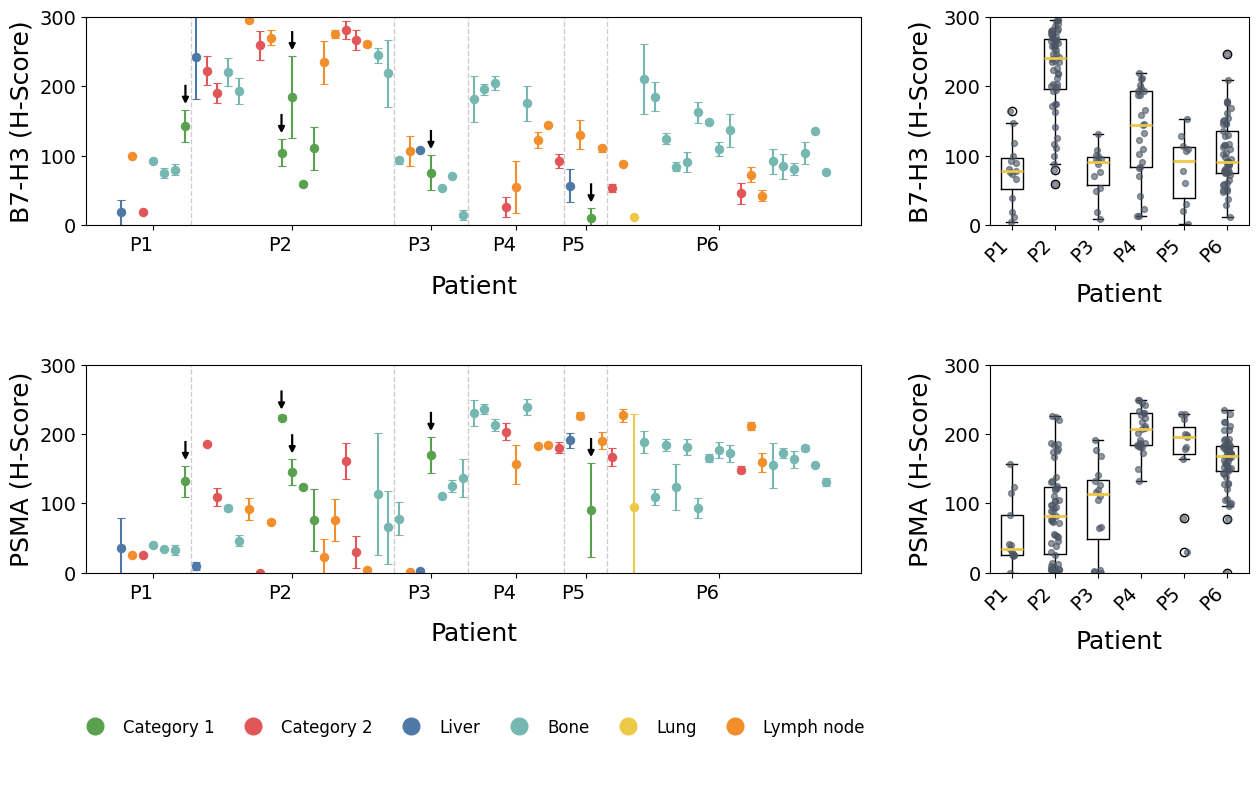

In [292]:
patient_col = "Patient ID"
tissue_col = "Tissue_merged"
primary_col = "Tissue"

# palette you already use for tissues (same across rows)
uniq_tissues = df[tissue_col].astype(str).fillna("NA").unique().tolist()
TABLEAU10 = ["#4E79A7","#F28E2B","#E15759","#76B7B2","#59A14F",
             "#EDC948","#B07AA1","#FF9DA7","#9C755F","#BAB0AC"]
SET2 = ["#E377C2","#AA4499","#8DA0CB","#E78AC3","#A6D854","#FFD92F","#E5C494","#B3B3B3"]
palette = {t: (TABLEAU10 + SET2)[i % (len(TABLEAU10)+len(SET2))] for i, t in enumerate(uniq_tissues)}

fig = build_panel(
    df, palette,
    legend_row_height=0.36,   # make even taller if needed
    patient_col = patient_col,
    tissue_col = tissue_col, 
    primary_col = primary_col,
    hspace=0.85, wspace=0.25, # more space between plots
    label_fontsize=18,        # big axis titles
    tick_fontsize=14,         # big tick labels
    vline_color="#C8C8C8", vline_alpha=0.9,
    legend_bbox_y=0.8,        # place legend lower in its row
    x_label="Patient"
)
plt.show()


In [293]:
# assume you have a Matplotlib figure handle called `fig`
out_base = "/projects/eshenderov-hpc/Shivang/projects/B7-H3 ADC Manuscript/figures/B7-H3_PSMA_IHC/B7H3_PSMA_IHC_panel"  # no extension

# 1) PDF (vector) — dpi is ignored for vectors, but keep for any rasterized artists
fig.savefig(f"{out_base}.pdf",
            bbox_inches="tight",
            transparent=False)   # set True if you want transparent background

# 2) TIFF (raster) at 600 dpi with LZW compression
fig.savefig(f"{out_base}.tif",
            dpi=600,
            bbox_inches="tight",
            pil_kwargs={"compression": "tiff_lzw"})  # needs Pillow backend

/local/ssharm55/2327612/ipykernel_2052721/41456707.py:41: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[tissue_col]):
/local/ssharm55/2327612/ipykernel_2052721/41456707.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/local/ssharm55/2327612/ipykernel_2052721/41456707.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for pid, sub in

['P1', 'P2', 'P3', 'P4', 'P5', 'P6']
['P1', 'P2', 'P3', 'P4', 'P5', 'P6']


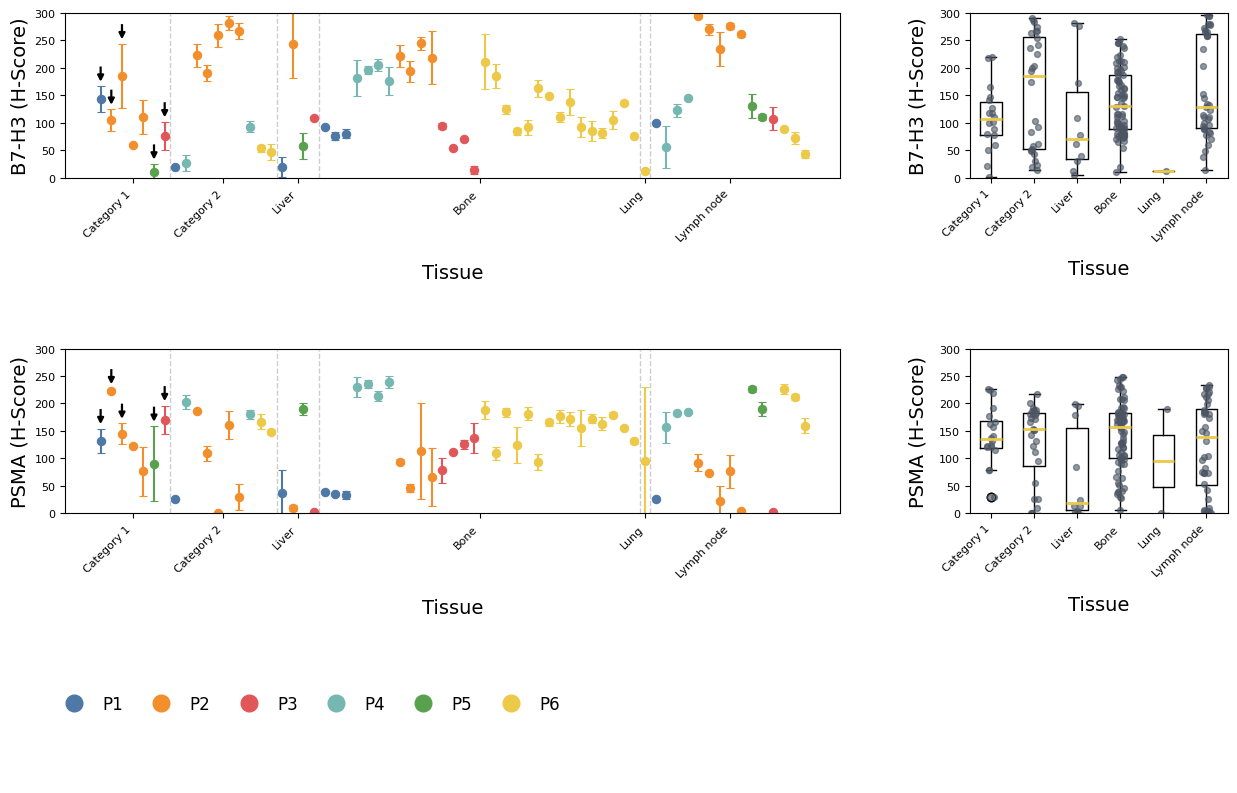

In [294]:
# palette you already use for tissues (same across rows)
uniq_tissues = df["Patient ID"].astype(str).fillna("NA").unique().tolist()
TABLEAU10 = ["#4E79A7","#F28E2B","#E15759","#76B7B2","#59A14F",
             "#EDC948","#B07AA1","#FF9DA7","#9C755F","#BAB0AC"]
SET2 = ["#E377C2","#AA4499","#8DA0CB","#E78AC3","#A6D854","#FFD92F","#E5C494","#B3B3B3"]
palette = {t: (TABLEAU10 + SET2)[i % (len(TABLEAU10)+len(SET2))] for i, t in enumerate(uniq_tissues)}

fig = build_panel(
    df, palette,
    legend_row_height=0.60,   # make even taller if needed
    patient_col = "Tissue_merged", 
    tissue_col = "Patient ID", 
    primary_col = "Tissue",
    hspace=1.20, wspace=0.25, # more space between plots
    label_fontsize=14,        # big axis titles
    tick_fontsize=8,         # big tick labels
    vline_color="#C8C8C8", vline_alpha=0.9,
    legend_bbox_y=0.8,        # place legend lower in its row
    xlabel_angle = 45, 
    x_label="Tissue"
)
plt.show()

In [ ]:
# assume you have a Matplotlib figure handle called `fig`
out_base = "/projects/eshenderov-hpc/Shivang/projects/B7-H3 ADC Manuscript/figures/B7-H3_PSMA_IHC/B7H3_PSMA_IHC_panel_by_tissue"  # no extension

# 1) PDF (vector) — dpi is ignored for vectors, but keep for any rasterized artists
fig.savefig(f"{out_base}.pdf",
            bbox_inches="tight",
            transparent=False)   # set True if you want transparent background

# 2) TIFF (raster) at 600 dpi with LZW compression
fig.savefig(f"{out_base}.tif",
            dpi=600,
            bbox_inches="tight",
            pil_kwargs={"compression": "tiff_lzw"})  # needs Pillow backend

In [ ]:
def scatter_with_regression(
    df: pd.DataFrame,
    x_col: str = "PSMA",
    y_col: str = "B7-H3",
    figsize=(6, 5),
    annotate_xy=(0.05, 0.95)  # axes fraction (left, top)
):
    d = df[[x_col, y_col]].copy()

    # Coerce to numeric and drop bad rows
    d[x_col] = pd.to_numeric(d[x_col], errors="coerce")
    d[y_col] = pd.to_numeric(d[y_col], errors="coerce")
    d = d.dropna(subset=[x_col, y_col])

    x = d[x_col].values
    y = d[y_col].values

    # Pearson correlation
    r, p = pearsonr(x, y)
    r2 = r**2

    # Simple linear regression (y = a + b*x)
    b, a = np.polyfit(x, y, deg=1)  # returns slope b, intercept a

    # For plotting the line nicely across the data range
    x_line = np.linspace(np.min(x), np.max(x), 100)
    y_line = a + b * x_line

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x, y, 'o', alpha=0.7)                # scatter
    ax.plot(x_line, y_line)                      # regression line (default style/colors)

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f"{y_col} vs {x_col} (Pearson r, linear fit)")

    # Annotation with intercept and R^2
    text = (
        f"y = {a:.3f} + {b:.3f}·x\n"
        f"R² = {r2:.3f}  (r = {r:.3f}, p = {p:.3g})"
    )
    ax.annotate(
        text,
        xy=annotate_xy,
        xycoords='axes fraction',
        ha='left', va='top',
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.8)
    )

    fig.tight_layout()
    return fig, ax

In [ ]:
df_out[]

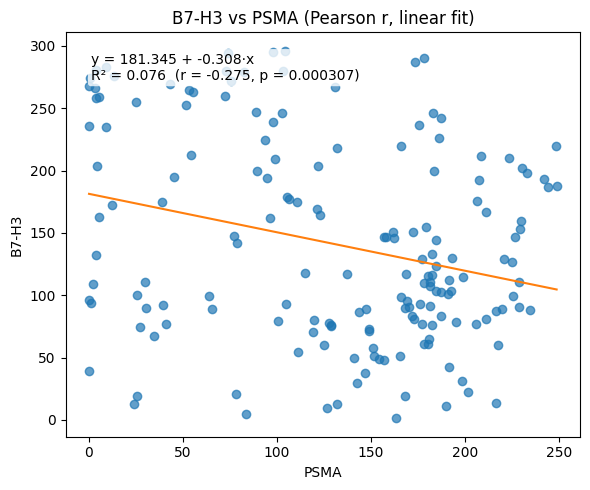

In [ ]:
fig, ax = scatter_with_regression(df, x_col="PSMA", y_col="B7-H3")
plt.show()

In [ ]:
np.std(df_out["B7-H3"])/np.mean(df_out["B7-H3"])

np.float64(0.5686136857865169)

In [ ]:
np.std(df_out["PSMA"])/np.mean(df_out["PSMA"])

np.float64(0.5420654394130917)

In [ ]:
sum(df_out["B7-H3"] == 0)

0

In [ ]:
np.unique(df_out["Location"])

array(['Abdominal LN', 'Central liver', 'Cervical 6', 'Diaphragma',
       'Hilar LN', 'IDC RDA', 'Invasive RB2', 'L 10th rib', 'L 1st rib',
       'L 3rd Rib', 'L 3rd rib', 'L 5th rib', 'L adrenal', 'L medias LN',
       'L pubis skin', 'L1', 'L2', 'L3', 'LC1', 'LDA', 'LEP', 'Left SV',
       'Left clavicle', 'Left liver', 'Lumbar ver', 'Lumbar vert 4',
       'Mesenteric LN', 'Periaort LN', 'Periesoph LN', 'Periuret LN',
       'Post cheswall', 'R 1st rib', 'R 2nd rib', 'R 3rd rib',
       'R 4th rib', 'R 5th rib', 'R 7th rib', 'R C iliac LN',
       'R Centr Liver', 'R Tibia', 'R ext Iliac LN', 'R lung lower',
       'R periesop LN', 'Right Liver', 'Right SV', 'Spleen', 'T11', 'T9',
       'Thoracic 10', 'Thoracic ver', 'Vertebrae 1', 'Vertebrae 2',
       'Vertebrae 3', 'aortic arch LN', 'aortic bif', 'carinal LN',
       'chest wall', 'chestwall', 'liver philerLN', 'paratrach LN',
       'soft tis L rib1', 'softtis 5rib'], dtype=object)

In [ ]:
df_out["Bispecific"] = df_out["B7-H3"] + df_out["PSMA"]

/local/ssharm55/2176936/ipykernel_3175068/1705955387.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=True, patch_artist=False)


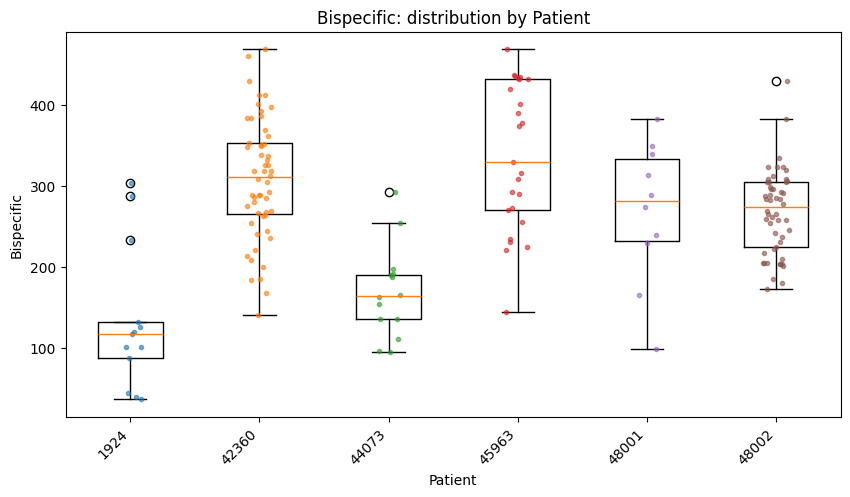

In [ ]:
fig, ax = boxplot_hscore_by_patient(df_out, marker_col="Bispecific", patient_col="Patient ID")
plt.show()

In [ ]:
df.head()

,Patient ID,BlockID,Location,B7-H3,PSMA
0,1924,42751,Left liver,12.546125,24.107143
1,1924,42751,Left liver,38.885201,0.111483
2,1924,42751,Left liver,4.585868,83.465187
3,1924,42762,Hilar LN,100.307312,25.698757
4,1924,42766,Diaphragma,18.85626,25.802752


In [ ]:
def _cv(series, ddof=1):
    m = series.mean()
    if m == 0 or np.isnan(m): 
        return np.nan
    s = series.std(ddof=ddof)
    return s / m

def compute_cv_table(
    df: pd.DataFrame,
    marker_cols=("B7-H3", "PSMA", "Bispecific"),
    level="intratumoral",                 # "intratumoral" or "intrapatient"
    patient_col="Patient ID",
    tissue_col="Location",
    ddof=1,
    min_n=2
) -> pd.DataFrame:
    """
    Returns a table with one row per group (depending on `level`) and
    CVs for each marker. Groups with < min_n observations are dropped.
    """
    d = df.copy()
    # coerce markers to numeric, create 'Bispecific' if missing
    for m in marker_cols:
        if m == "Bispecific" and "Bispecific" not in d.columns:
            if ("B7-H3" in d.columns) and ("PSMA" in d.columns):
                d["Bispecific"] = pd.to_numeric(d["B7-H3"], errors="coerce") + pd.to_numeric(d["PSMA"], errors="coerce")
        d[m] = pd.to_numeric(d[m], errors="coerce")
    d = d.dropna(subset=[c for c in marker_cols if c in d.columns])

    # choose grouping level
    if level == "intratumoral":
        group_cols = [patient_col, tissue_col]   # within (patient, tissue)
    elif level == "intrapatient":
        group_cols = [patient_col]              # within patient (all tissues pooled)
    else:
        raise ValueError("level must be 'intratumoral' or 'intrapatient'")

    # aggregate CV per group for each marker
    out = (
        d.groupby(group_cols, dropna=False)
         .apply(lambda g: pd.Series(
             {m: _cv(g[m].dropna(), ddof=ddof) for m in marker_cols if m in g.columns} |
             {"n": len(g)}
         ))
         .reset_index()
    )

    # keep groups with enough observations for a meaningful CV
    out = out[out["n"] >= min_n].reset_index(drop=True)
    return out

def paired_cv_tests(cv_table: pd.DataFrame, markers=("B7-H3", "PSMA", "Bispecific")) -> pd.DataFrame:
    """
    For each pair of markers, run paired tests on CVs across the same groups.
    Uses Wilcoxon signed-rank (robust) and paired t-test (for reference).
    """
    results = []
    present = [m for m in markers if m in cv_table.columns]
    for a, b in combinations(present, 2):
        sub = cv_table[[a, b]].dropna()
        if len(sub) == 0:
            continue
        x, y = sub[a].values, sub[b].values
        # Wilcoxon (two-sided)
        try:
            w_stat, w_p = wilcoxon(x, y, zero_method="wilcox", alternative="two-sided")
        except ValueError:
            w_stat, w_p = np.nan, np.nan  # e.g., if all diffs are zero
        # Paired t-test (normality assumption)
        t_stat, t_p = ttest_rel(x, y, nan_policy="omit")
        diff = (x - y)
        results.append({
            "marker_A": a, "marker_B": b,
            "N_pairs": len(diff),
            "median_diff_CV(A-B)": np.nanmedian(diff),
            "mean_diff_CV(A-B)":   np.nanmean(diff),
            "wilcoxon_stat": w_stat, "wilcoxon_p": w_p,
            "ttest_t": t_stat,      "ttest_p": t_p,
        })
    return pd.DataFrame(results)

def paired_cv_plot(cv_table: pd.DataFrame, markers=("B7-H3", "PSMA", "Bispecific"),
                   title="Coefficient of Variation by marker (paired across groups)"):
    """
    Simple paired scatter to *show* CV differences per group.
    """
    present = [m for m in markers if m in cv_table.columns]
    x_positions = np.arange(len(present))  # 0,1,2
    fig, ax = plt.subplots(figsize=(6, 5))

    # draw paired lines per group
    vals = cv_table[present].dropna().values  # shape: (G, K)
    for row in vals:
        ax.plot(x_positions, row, '-o', alpha=0.3)

    # overlay medians per marker
    medians = np.nanmedian(vals, axis=0)
    ax.plot(x_positions, medians, 's-', linewidth=2)

    ax.set_xticks(x_positions)
    ax.set_xticklabels(present)
    ax.set_ylabel("CV (sd / mean)")
    ax.set_title(title)
    fig.tight_layout()
    return fig, ax

Intratumoral CV comparisons:
  marker_A    marker_B  N_pairs  median_diff_CV(A-B)  mean_diff_CV(A-B)  \
0    B7-H3        PSMA       55             0.013944          -0.053230   
1    B7-H3  Bispecific       55             0.029588           0.074928   
2     PSMA  Bispecific       55             0.005500           0.128159   

   wilcoxon_stat  wilcoxon_p   ttest_t   ttest_p  
0          734.0    0.762936 -1.089202  0.280902  
1          363.0    0.000649  3.203133  0.002281  
2          485.0    0.016946  3.374074  0.001377  


/local/ssharm55/2176936/ipykernel_3175068/2909624724.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(


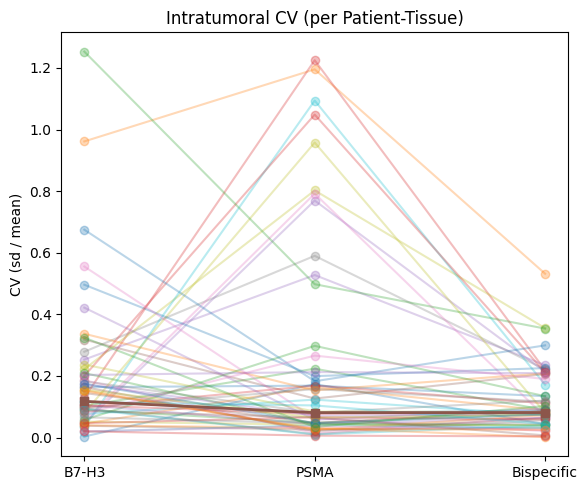

/local/ssharm55/2176936/ipykernel_3175068/2909624724.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(


Intrapatient CV comparisons:
  marker_A    marker_B  N_pairs  median_diff_CV(A-B)  mean_diff_CV(A-B)  \
0    B7-H3        PSMA        6             0.017123          -0.006650   
1    B7-H3  Bispecific        6             0.169907           0.153596   
2     PSMA  Bispecific        6             0.104857           0.160246   

   wilcoxon_stat  wilcoxon_p   ttest_t   ttest_p  
0           10.0      1.0000 -0.042543  0.967713  
1            1.0      0.0625  2.856499  0.035552  
2            5.0      0.3125  1.436084  0.210466  


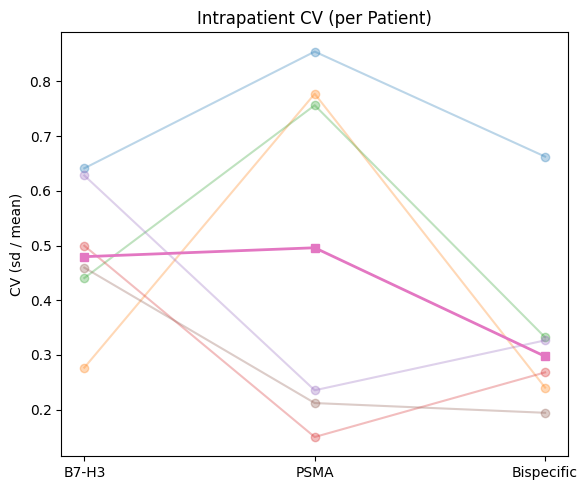

In [ ]:
# 1) Intratumoral: CV across biopsies within (Patient, Tissue)
cv_intra_tumor = compute_cv_table(
    df_out, 
    marker_cols=("B7-H3", "PSMA", "Bispecific"),
    level="intratumoral",
    patient_col="Patient ID",
    tissue_col="Location",
    ddof=1,
    min_n=2
)

stats_intra_tumor = paired_cv_tests(cv_intra_tumor, markers=("B7-H3", "PSMA", "Bispecific"))
print("Intratumoral CV comparisons:")
print(stats_intra_tumor)

# Optional plot to visualize paired CVs across markers
paired_cv_plot(cv_intra_tumor, markers=("B7-H3", "PSMA", "Bispecific"),
               title="Intratumoral CV (per Patient-Tissue)")
plt.show()

# 2) Intrapatient: CV across all biopsies within a patient (ignoring tissue)
cv_intra_patient = compute_cv_table(
    df_out, 
    marker_cols=("B7-H3", "PSMA", "Bispecific"),
    level="intrapatient",
    patient_col="Patient ID",
    tissue_col="Location",
    ddof=1,
    min_n=2
)

stats_intra_patient = paired_cv_tests(cv_intra_patient, markers=("B7-H3", "PSMA", "Bispecific"))
print("Intrapatient CV comparisons:")
print(stats_intra_patient)

paired_cv_plot(cv_intra_patient, markers=("B7-H3", "PSMA", "Bispecific"),
               title="Intrapatient CV (per Patient)")
plt.show()

In [ ]:
df_out["Bispecific_Norm"] = df_out["B7-H3"]/np.median(df_out["B7-H3"])*100 + df_out["PSMA"]/np.median(df_out["PSMA"])*100
df_out["Bispecific_Norm"] = df_out["Bispecific_Norm"]/np.median(df_out["Bispecific_Norm"])*100

Intratumoral CV comparisons:
  marker_A         marker_B  N_pairs  median_diff_CV(A-B)  mean_diff_CV(A-B)  \
0    B7-H3             PSMA       55             0.013944          -0.053230   
1    B7-H3  Bispecific_Norm       55             0.028770           0.076647   
2     PSMA  Bispecific_Norm       55             0.004146           0.129878   

   wilcoxon_stat  wilcoxon_p   ttest_t   ttest_p  
0          734.0    0.762936 -1.089202  0.280902  
1          339.0    0.000305  3.247353  0.002005  
2          537.0    0.050914  3.293169  0.001752  


/local/ssharm55/2176936/ipykernel_3175068/2909624724.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(


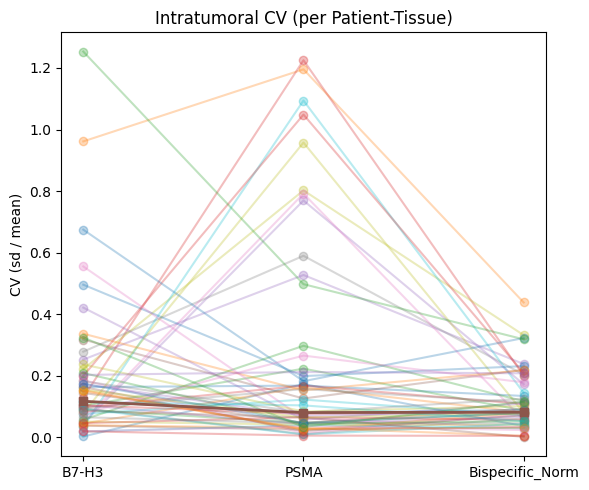

/local/ssharm55/2176936/ipykernel_3175068/2909624724.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(


Intrapatient CV comparisons:
  marker_A         marker_B  N_pairs  median_diff_CV(A-B)  mean_diff_CV(A-B)  \
0    B7-H3             PSMA        6             0.017123          -0.006650   
1    B7-H3  Bispecific_Norm        6             0.178407           0.153927   
2     PSMA  Bispecific_Norm        6             0.101465           0.160576   

   wilcoxon_stat  wilcoxon_p   ttest_t   ttest_p  
0           10.0      1.0000 -0.042543  0.967713  
1            1.0      0.0625  3.254981  0.022571  
2            5.0      0.3125  1.337663  0.238623  


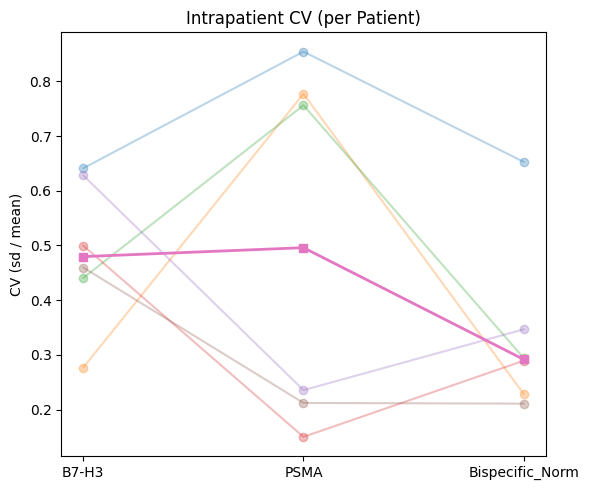

In [ ]:
# 1) Intratumoral: CV across biopsies within (Patient, Tissue)
cv_intra_tumor = compute_cv_table(
    df_out, 
    marker_cols=("B7-H3", "PSMA", "Bispecific_Norm"),
    level="intratumoral",
    patient_col="Patient ID",
    tissue_col="Location",
    ddof=1,
    min_n=2
)

stats_intra_tumor = paired_cv_tests(cv_intra_tumor, markers=("B7-H3", "PSMA", "Bispecific_Norm"))
print("Intratumoral CV comparisons:")
print(stats_intra_tumor)

# Optional plot to visualize paired CVs across markers
paired_cv_plot(cv_intra_tumor, markers=("B7-H3", "PSMA", "Bispecific_Norm"),
               title="Intratumoral CV (per Patient-Tissue)")
plt.show()

# 2) Intrapatient: CV across all biopsies within a patient (ignoring tissue)
cv_intra_patient = compute_cv_table(
    df_out, 
    marker_cols=("B7-H3", "PSMA", "Bispecific_Norm"),
    level="intrapatient",
    patient_col="Patient ID",
    tissue_col="Location",
    ddof=1,
    min_n=2
)

stats_intra_patient = paired_cv_tests(cv_intra_patient, markers=("B7-H3", "PSMA", "Bispecific_Norm"))
print("Intrapatient CV comparisons:")
print(stats_intra_patient)

paired_cv_plot(cv_intra_patient, markers=("B7-H3", "PSMA", "Bispecific_Norm"),
               title="Intrapatient CV (per Patient)")
plt.show()

In [ ]:
def _freedman_diaconis_bins(x):
    """Number of bins via Freedman–Diaconis rule (robust to outliers)."""
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if x.size < 2:
        return 1
    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25
    if iqr == 0:
        return min(50, max(1, int(np.sqrt(x.size))))  # fallback
    h = 2 * iqr * (x.size ** (-1/3))
    if h == 0:
        return min(50, max(1, int(np.sqrt(x.size))))
    bins = int(np.ceil((x.max() - x.min()) / h))
    return max(1, min(bins, 100))

def plot_hscore_histograms(
    df: pd.DataFrame,
    b7_col: str = "B7-H3",
    psma_col: str = "PSMA",
    make_panel: bool = True,      # panel of 3 separate histograms
    make_overlay: bool = False,   # also make a single overlaid histogram
    density: bool = True,        # True→show probability density instead of counts
    bins: int | None = None,      # if None, auto via Freedman–Diaconis on combined data
    figsize_panel=(12, 4),
    figsize_overlay=(6, 4),
):
    d = df.copy()

    # Coerce to numeric
    d[b7_col] = pd.to_numeric(d[b7_col], errors="coerce")
    d[psma_col] = pd.to_numeric(d[psma_col], errors="coerce")

    # Create Bispecific if missing
    if "Bispecific" not in d.columns:
        d["Bispecific_Norm"] = d[b7_col] + d[psma_col]
    else:
        d["Bispecific_Norm"] = pd.to_numeric(d["Bispecific_Norm"], errors="coerce")

    # Extract arrays and drop NaNs
    b7   = d[b7_col].dropna().values
    psma = d[psma_col].dropna().values
    bi   = d["Bispecific_Norm"].dropna().values

    # Shared bins across all three for comparability
    if bins is None:
        all_vals = np.concatenate([v for v in [b7, psma, bi] if v.size > 0])
        if all_vals.size == 0:
            raise ValueError("No numeric values found in the provided columns.")
        bins = _freedman_diaconis_bins(all_vals)

    figs_axes = []

    # Panel: three side-by-side histograms
    if make_panel:
        fig, axes = plt.subplots(1, 3, figsize=figsize_panel, sharey=True)
        for ax, data, title in zip(
            axes,
            [b7, psma, bi],
            [b7_col, psma_col, "Bispecific_Norm"],
        ):
            ax.hist(data, bins=bins, density=density)
            ax.set_title(title)
            ax.set_xlabel("H-score")
            ax.set_ylabel("Density" if density else "Count")
        fig.suptitle("H-score Histograms")
        fig.tight_layout()
        figs_axes.append((fig, axes))

    # Overlay: all three on one axis (with transparency)
    if make_overlay:
        fig2, ax2 = plt.subplots(figsize=figsize_overlay)
        ax2.hist(b7, bins=bins, alpha=0.5, density=density, label=b7_col)
        ax2.hist(psma, bins=bins, alpha=0.5, density=density, label=psma_col)
        ax2.hist(bi, bins=bins, alpha=0.5, density=density, label="Bispecific")
        ax2.set_xlabel("H-score")
        ax2.set_ylabel("Density" if density else "Count")
        ax2.set_title("H-score Histogram (Overlay)")
        ax2.legend()
        fig2.tight_layout()
        figs_axes.append((fig2, ax2))

    return figs_axes


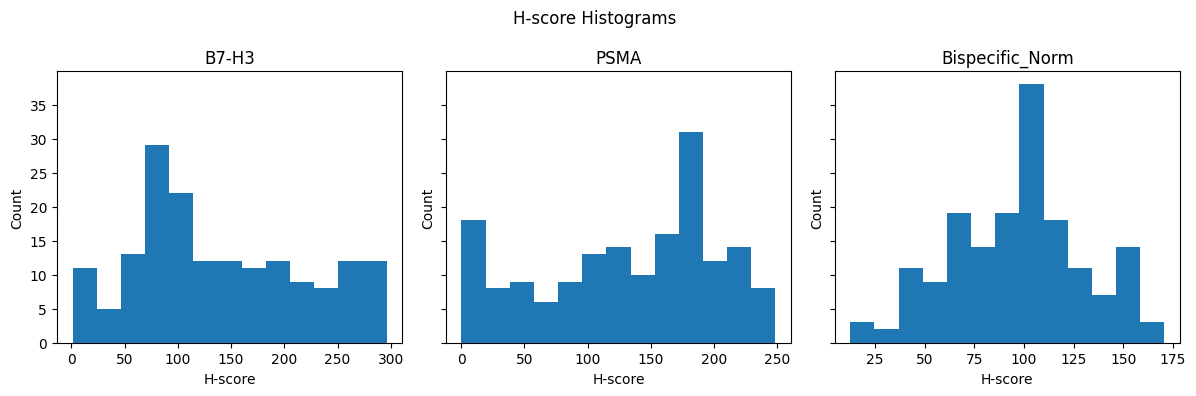

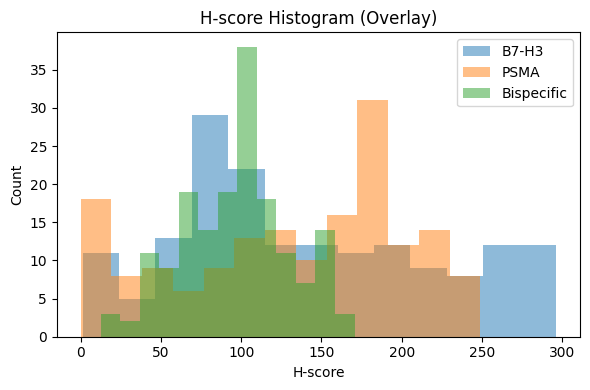

In [ ]:
plot_hscore_histograms(df_out, b7_col="B7-H3", psma_col="PSMA",
                       make_panel=True, make_overlay=True, density=False)
plt.show()

In [ ]:
def normality_report(
    df: pd.DataFrame,
    cols = ("B7-H3", "PSMA", "Bispecific_Norm"),
    alpha: float = 0.05,
    show_plots: bool = True,
    max_for_shapiro: int = 5000,  # Shapiro is reliable up to ~5k obs
):
    df = df.copy()

    # Coerce to numeric; keep only needed columns
    for c in cols:
        if c not in df.columns: 
            raise KeyError(f"Column '{c}' not found.")
        df[c] = pd.to_numeric(df[c], errors="coerce")

    results = []
    for c in cols:
        x = df[c].dropna().values
        n = len(x)
        if n < 3:
            results.append({
                "variable": c, "n": n, "mean": np.nan, "sd": np.nan,
                "skew": np.nan, "excess_kurtosis": np.nan,
                "shapiro_W": np.nan, "shapiro_p": np.nan,
                "dagostino_K2": np.nan, "dagostino_p": np.nan,
                "anderson_A2": np.nan, "anderson_sig_5%_critical": np.nan,
                "reject_normal_(any_test @alpha)": np.nan
            })
            continue

        # Summary stats
        mean = float(np.mean(x))
        sd   = float(np.std(x, ddof=1))
        skew = float(stats.skew(x, bias=False))
        exk  = float(stats.kurtosis(x, fisher=True, bias=False))  # excess kurtosis

        # Tests
        # 1) Shapiro–Wilk (only if not too large)
        if n <= max_for_shapiro:
            W, p_shapiro = stats.shapiro(x)
        else:
            W, p_shapiro = (np.nan, np.nan)

        # 2) D’Agostino K² (skew + kurtosis)
        K2, p_k2 = stats.normaltest(x, nan_policy="omit")

        # 3) Anderson–Darling (gives critical values at preset sig levels)
        ad = stats.anderson(x, dist="norm")  # ad.statistic, ad.critical_values, ad.significance_level
        # get 5% critical value
        try:
            idx5 = list(ad.significance_level).index(5.0)
            ad_crit_5 = float(ad.critical_values[idx5])
        except ValueError:
            ad_crit_5 = np.nan

        reject_any = (
            (not np.isnan(p_shapiro) and p_shapiro < alpha) or
            (p_k2 < alpha) or
            (not np.isnan(ad_crit_5) and ad.statistic > ad_crit_5)
        )

        results.append({
            "variable": c, "n": n, "mean": mean, "sd": sd,
            "skew": skew, "excess_kurtosis": exk,
            "shapiro_W": W, "shapiro_p": p_shapiro,
            "dagostino_K2": K2, "dagostino_p": p_k2,
            "anderson_A2": ad.statistic, "anderson_sig_5%_critical": ad_crit_5,
            "reject_normal_(any_test @alpha)": reject_any
        })

        # Plots
        if show_plots:
            fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))
            # Histogram (same-style defaults)
            axes[0].hist(x, bins='auto')
            axes[0].set_title(f"{c} histogram")
            axes[0].set_xlabel(c); axes[0].set_ylabel("Count")

            # Q-Q plot
            stats.probplot(x, dist="norm", plot=axes[1])
            axes[1].set_title(f"{c} Q–Q plot")
            fig.suptitle(f"{c}: normality diagnostics", y=1.02)
            fig.tight_layout()
            plt.show()

    return pd.DataFrame(results)




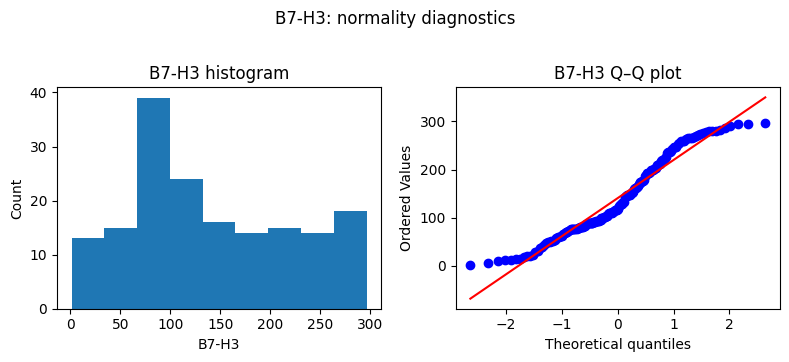

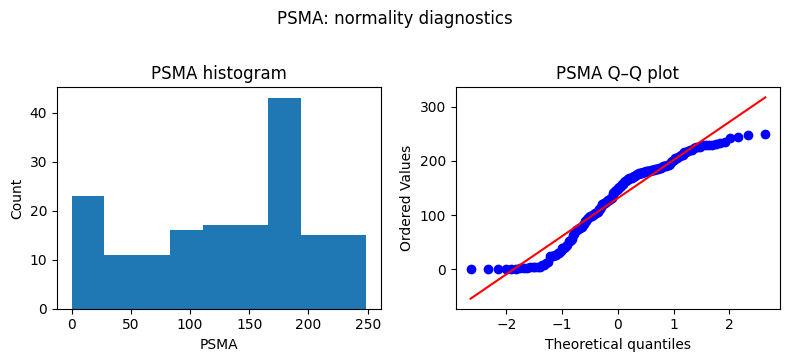

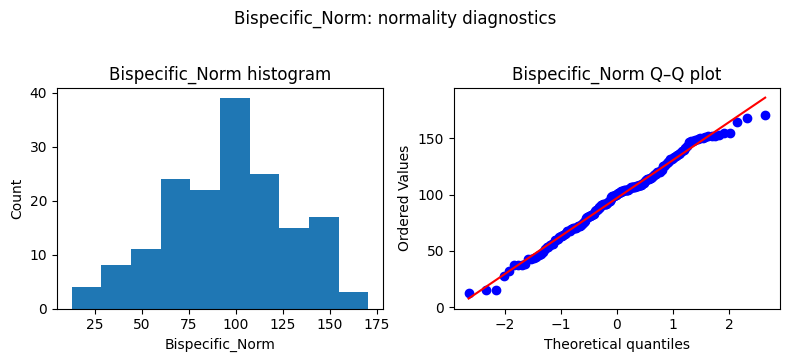

          variable    n        mean         sd      skew  excess_kurtosis  \
0            B7-H3  168  140.732149  80.261456  0.332956        -0.984443   
1             PSMA  168  131.708418  71.608018 -0.427351        -0.968187   
2  Bispecific_Norm  168   96.836869  33.455330 -0.142198        -0.331453   

   shapiro_W     shapiro_p  dagostino_K2   dagostino_p  anderson_A2  \
0   0.949919  1.109718e-05     29.417447  4.093384e-07     2.741161   
1   0.935811  7.639388e-07     29.524849  3.879364e-07     3.356250   
2   0.989809  2.706741e-01      1.458193  4.823445e-01     0.417014   

   anderson_sig_5%_critical  reject_normal_(any_test @alpha)  
0                     0.769                             True  
1                     0.769                             True  
2                     0.769                            False  


In [ ]:
tbl = normality_report(df_out, cols=["B7-H3", "PSMA", "Bispecific_Norm"], alpha=0.05, show_plots=True)
print(tbl)

In [ ]:
organ_map = {
    "Left liver": "Liver",
    "Diaphragma": "Muscle",
    "Vertebrae 2": "Bone",
    "Vertebrae 3": "Bone",
    "Vertebrae 1": "Bone",
    "Hilar LN": "Lymph node",
    "LDA": "Primary",
    "Central liver": "Liver",
    "chest wall": "Bone & soft tissue",
    "softtis 5rib": "Bone & soft tissue",
    "chestwall": "Bone & soft tissue",
    "R 3rd rib": "Bone",
    "R 4th rib": "Bone",
    "Periesoph LN": "Lymph node",
    "aortic arch LN": "Lymph node",
    "Invasive RB2": "Primary",
    "IDC RDA": "Primary",
    "Right SV": "Seminal vesicle",
    "Left SV": "Seminal vesicle",
    "Abdominal LN": "Lymph node",
    "Periaort LN": "Lymph node",
    "Post cheswall": "Bone & soft tissue",
    "aortic bif": "Soft tissue",
    "Thoracic ver": "Bone",
    "Lumbar ver": "Bone",
    "Carinal LN": "Lymph node",
    "L 3rd rib": "Bone",
    "LEP": "Primary",
    "Lumbar vert 4": "Bone",
    "Lung L upper": "Lung",
    "lung R lower": "Lung",
    "R Centr Liver": "Liver",
    "R ext Iliac LN": "Lymph node",
    "R Tibia": "Bone",
    "Thoracic 10": "Bone",
    "L adrenal": "Adrenal",
    "paratrach LN": "Lymph node",
    "Cervical 6": "Soft tissue?",
    "carinal LN": "Lymph node",
    "Mesenteric LN": "Lymph node",
    "L 10th rib": "Bone",
    "soft tis L rib1": "Bone",
    "R 7th rib": "Bone",
    "paraaortic LN": "Lymph node",
    "Mediastinal LN": "Lymph node",
    "Paraeuso LN": "Lymph node",
    "Right Liver": "Liver",
    "liver philerLN": "Lymph node",
    "LC1": "Primary",
    "Periuret LN": "Lymph node",
    "R lung lower": "Lung",
    "R C iliac LN": "Lymph node",
    "Spleen": "Spleen",
    "L pubis skin": "Skin",
    "R periesop LN": "Lymph node",
    "T11": "Bone",
    "L3": "Bone",
    "L 1st rib": "Bone",
    "L2": "Bone",
    "L medias LN": "Lymph node",
    "T9": "Bone",
    "L1": "Bone",
    "R 1st rib": "Bone",
    "L 3rd Rib": "Bone",
    "T12": "Bone",
    "Left clavicle": "Bone",
    "R 2nd rib": "Bone",
    "R 3rd rib": "Bone",
    "R 5th rib": "Bone",
    "L 5th rib": "Bone",
    "L inguin skin": "Skin",
    "periaort LN": "Lymph node"
}
